# Session 1 (Exercise) - EPEX SPOT Data Analysis

This is the exercise of the first session of the lecture **1743 - Data Mining and Decision Support Systems** held by Prof. Nils Löhndorf at the Vienna University of Economics and Business during the winter term 2016/2017. It was conducted by group WU6 consisting of Boris Haviar, David Riobo Barba, Arel Topulli and Manuel Raffel.

---
*1. Manually collect data from the entire month of September. Use pd.concat() to merge all dataframes together into a single one. The easiest approach is to create a list at the very top to which you append the new dataframes and then insert this list into concat() function. Optional: Use a loop to automatically loop over the past couple of weeks.*

The used libraries correspond to the ones used during the first lecture, namely *pandas* for data analysis, *urllib* to load data from the web and *BeautifulSoup* to parse the received data. In addition, the *datetime*-package is imported for additional time-related functionality and *seaborn* and *matplotlib* provide additional possibilities for data visualization.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import datetime
import seaborn as sb
import matplotlib.pylab as plt

The following application will grab the price data of September 2016 from the EPEX SPOT website. The dataframe `dfEPEX` is gathering all hourly price data.

In [2]:
date = datetime.date(2016, 9, 1) # specify the first day of the month to grab data for
dfEPEX = pd.DataFrame() # dataframe to gather all hourly price data from EPEX SPOT

As the EPEX SPOT URL will always return one week (seven days) worth of data up until the date specified in the query, it has to be repeated until the whole specified month was collected. Therefore, after each loop the "current" date is increased by seven days until the next month is reached (the loop actually works a bit differently, but that's the basic idea behind it). The newly collected data is recursively appended to the already collected data frame.

In [3]:
while(date.month == 9):
    url = urllib.urlopen('https://www.epexspot.com/en/market-data/dayaheadauction/auction-table/' + (date + timedelta(6)).strftime('%Y-%m-%d'))
    url = url.read()
    soup = BeautifulSoup(url, 'lxml')
    table = soup.find_all('table', class_='list hours responsive')[1]
    df = pd.read_html(str(table), header=0, encoding='UTF-8')[0]
    df = df.drop(['Unnamed: 0','Unnamed: 1'], axis=1)
    dfEPEX = pd.concat([dfEPEX,df], axis=1) # append currently read data to existing data frame
    date += timedelta(7)

As the last iteration also collects parts of the data from the next month (i.e. October), this data has to be deleted.

In [4]:
date -= timedelta(1) # adjust date by one day

# remove all columns with data from October
while(date.month == 10):
    dfEPEX = dfEPEX.drop([date.strftime('%a, %d/%m')], axis=1)
    date -= timedelta(1)

In order for the data frame to have a proper time based index, a new one which maches the collected data is generated using `pd.date_range` with 30 periods (days in September) time 24 hours per day.

In [5]:
index = pd.date_range(start='2016-09-01-00:00',periods=30*24,freq='h')
index

DatetimeIndex(['2016-09-01 00:00:00', '2016-09-01 01:00:00',
               '2016-09-01 02:00:00', '2016-09-01 03:00:00',
               '2016-09-01 04:00:00', '2016-09-01 05:00:00',
               '2016-09-01 06:00:00', '2016-09-01 07:00:00',
               '2016-09-01 08:00:00', '2016-09-01 09:00:00',
               ...
               '2016-09-30 14:00:00', '2016-09-30 15:00:00',
               '2016-09-30 16:00:00', '2016-09-30 17:00:00',
               '2016-09-30 18:00:00', '2016-09-30 19:00:00',
               '2016-09-30 20:00:00', '2016-09-30 21:00:00',
               '2016-09-30 22:00:00', '2016-09-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

As the created data frame `dfEPEX` contains both prices and volumes, they are extracted into their own data series.

In [6]:
EPEXprices = dfEPEX[::2].transpose().stack() # take every second row
EPEXprices.index = index # assign generated index to price data
EPEXprices.head() # verify extracted price data

2016-09-01 00:00:00   24.34
2016-09-01 01:00:00   23.73
2016-09-01 02:00:00   23.37
2016-09-01 03:00:00   22.98
2016-09-01 04:00:00   23.59
Freq: H, dtype: float64

In [7]:
EPEXvolumes = dfEPEX[1::2].transpose().stack() # take every second row starting one row in
EPEXvolumes.index = index # assign generated index to volume data
EPEXvolumes.head() # verify extracted volume data

2016-09-01 00:00:00   20591.10
2016-09-01 01:00:00   20466.30
2016-09-01 02:00:00   20430.70
2016-09-01 03:00:00   20499.60
2016-09-01 04:00:00   20465.20
Freq: H, dtype: float64

After successfully separating both types of collected data, they are put into individual columns of the new data frame `dfEPEXbase`.

In [8]:
dfEPEXbase = pd.DataFrame()
dfEPEXbase['Price'] = EPEXprices
dfEPEXbase['Volume'] = EPEXvolumes
dfEPEXbase.head() # verify generated data frame

,Price,Volume
2016-09-01 00:00:00,24.34,20591.10
2016-09-01 01:00:00,23.73,20466.30
2016-09-01 02:00:00,23.37,20430.70
2016-09-01 03:00:00,22.98,20499.60
2016-09-01 04:00:00,23.59,20465.20


---
*2. What is the peak price (9:00 to 20:00) for each day? What is the base price (daily mean)? Plot both prices in a single plot.*

To get the peak prices for each day (i.e. the arithmetic mean of the hourly prices between 09:00 and 20:00), the corresponding data is extracted from `dfEPEXbase`.

In [9]:
dfEPEXpeak = dfEPEXbase[(dfEPEXbase.index.hour >= 8) & (dfEPEXbase.index.hour < 20)]
dfEPEXpeak.head(15) # verify extracted data only contains 09:00 to 20:00

,Price,Volume
2016-09-01 08:00:00,41.08,26340.10
2016-09-01 09:00:00,38.24,28427.20
2016-09-01 10:00:00,34.92,31556.80
2016-09-01 11:00:00,32.98,34791.80
2016-09-01 12:00:00,29.93,36272.70
2016-09-01 13:00:00,28.68,36032.00
2016-09-01 14:00:00,27.87,35872.20
2016-09-01 15:00:00,27.88,33941.10
2016-09-01 16:00:00,28.96,31777.50
2016-09-01 17:00:00,34.06,28194.40


The arithmetic mean is calculated by grouping the peak prices per date and running the function `mean()` over each group before saving the results into `peakPricePerDay`.

In [10]:
peakPricePerDay = dfEPEXpeak.groupby(dfEPEXpeak.index.date).aggregate('mean')['Price']
peakPricePerDay.head() # verify calculation

2016-09-01   33.37
2016-09-02   32.15
2016-09-03   29.65
2016-09-04   23.80
2016-09-05   43.62
Name: Price, dtype: float64

The same is done to the entire collected data and the results are saved into `basePricePerDay`.

In [11]:
basePricePerDay = dfEPEXbase.groupby(dfEPEXbase.index.date).aggregate('mean')['Price']
basePricePerDay.head() # verify calculation

2016-09-01   31.26
2016-09-02   30.55
2016-09-03   29.49
2016-09-04   24.44
2016-09-05   36.78
Name: Price, dtype: float64

To make the data more comprehensible and ease plotting, a new data frame is created using the two average series.

In [12]:
dfPriceCalculations = pd.DataFrame(columns=['Peak Price','Base Price'])
dfPriceCalculations['Peak Price'] = peakPricePerDay
dfPriceCalculations['Base Price'] = basePricePerDay
dfPriceCalculations.head() # verify correct creation of consolidated data frame

,Peak Price,Base Price
2016-09-01,33.37,31.26
2016-09-02,32.15,30.55
2016-09-03,29.65,29.49
2016-09-04,23.80,24.44
2016-09-05,43.62,36.78


Finally, the collected data can easily be plotted using the `plot()`-function of the data frame.

(array([ 736209.,  736212.,  736215.,  736218.,  736221.,  736224.,
         736227.,  736230.,  736233.,  736236.]),
 <a list of 10 Text xticklabel objects>)

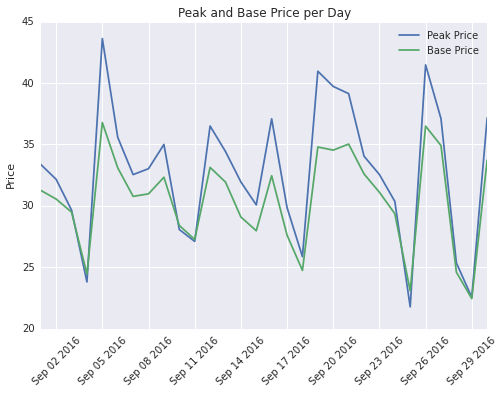

In [13]:
plot = dfPriceCalculations.plot(title='Peak and Base Price per Day')
plot.set(ylabel='Price')
plt.xticks(rotation=45)

---
*3. Is there a relationship between price and volume? What is a good way to measure this relationship? What would be a good way to visualize it?*

The correlation matrix below, generated by the `corr()`-function of the data frame, shows the correlation coefficient between price and volume. It is -0.09, which means that the more electricity is traded the cheaper it is and vice versa. Though, as it is close to zero, it is a very weak correlation.

In [14]:
dfEPEXbase.corr()

,Price,Volume
Price,1.00,-0.09
Volume,-0.09,1.00


To depict the relationship between two variables, a scatter plot is a good option. The regression line shows the direction and amount of the correlation.

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


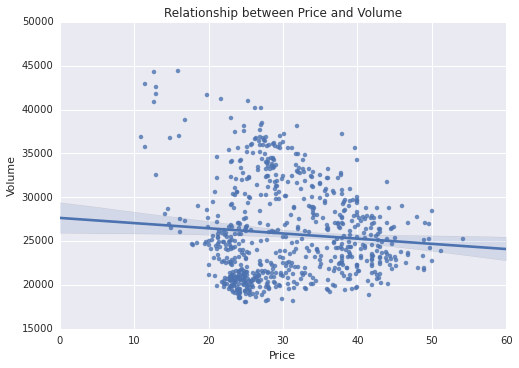

In [15]:
plot = sb.regplot(x='Price', y='Volume', data=dfEPEXbase, fit_reg=True) 
plot.set_title('Relationship between Price and Volume')

---
*4. Plot the distribution of hourly prices in one graph.*

The distribution of hourly prices can easily be seen by plotting a boxplot for every interval.

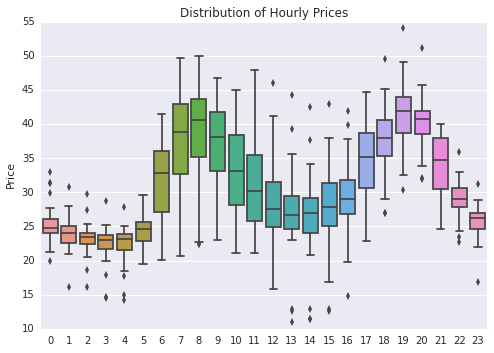

In [16]:
plot = sb.boxplot(x=dfEPEXbase.index.hour, y='Price', data=dfEPEXbase) # plot distribution of hourly prices
plot.set_title('Distribution of Hourly Prices')

---
*5. Plot the time series of weekly averages.*

The weekly averages can be directly plottet by grouping the whole price data by week (i.e. week number) and running the `mean()`-function over every group.

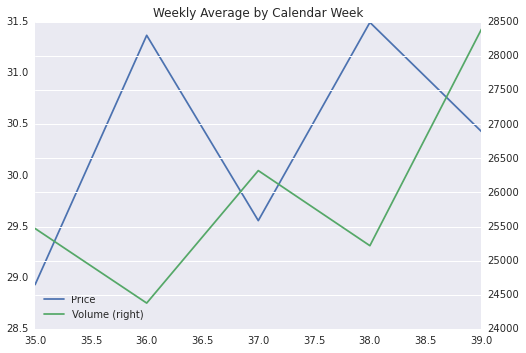

In [17]:
dfEPEXbase.groupby(dfEPEXbase.index.week).aggregate('mean').plot(y=['Price', 'Volume'], secondary_y='Volume', title='Weekly Average by Calendar Week') # plot time series of weekly means